In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()

In [2]:
df1 = pd.read_csv('click_data.csv', index_col=0)

In [45]:
print("data shape is: ", df1.shape)
df1.head()


data shape is:  (10000, 24)


,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [81]:
np.bincount(df1['click'])

array([8294, 1706])

In [80]:
df1.shape

(10000, 24)

In [40]:
8294 - 1706

6588

In [132]:
def undersampling():
    df2 = df1.copy()
    target = df2['click']
    count = 0
    holder = []
    for i in target:
        if count >= 7900:
                break
        if i == 0:
            holder.append(count)
        count += 1
       
    df2.drop(df2.index[holder], inplace=True)
    print(count)
    return df2

In [133]:
df2 = undersampling()


7900


In [134]:
df2.shape

(3453, 24)

In [135]:
np.bincount(df2['click'])

array([1747, 1706])

In [137]:
target = df2['click']
data = df2.drop(df1.columns[[0, 1]], axis=1)
data = pd.get_dummies(data)

In [138]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify=target, random_state=0)

In [139]:
print(X_train.shape)
print(X_test.shape)

(2589, 4658)
(864, 4658)


In [140]:
param_grid = {'randomforestclassifier__n_estimators': [50, 100], 
              'randomforestclassifier__max_depth': [10, 50, 100]}
pipe = make_pipeline(RandomForestClassifier())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("train score: {0:.3}".format(grid.score(X_train, y_train)))
print("test score: {0:.3}".format(grid.score(X_test, y_test)))

train score: 0.917
test score: 0.641


In [141]:
print(grid.best_estimator_)

Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])


In [143]:
from sklearn.metrics import precision_recall_curve
precision_rf, recall_rf, proba_rf = precision_recall_curve(y_test, grid.predict_proba(X_test)[:, 1]) 

[]

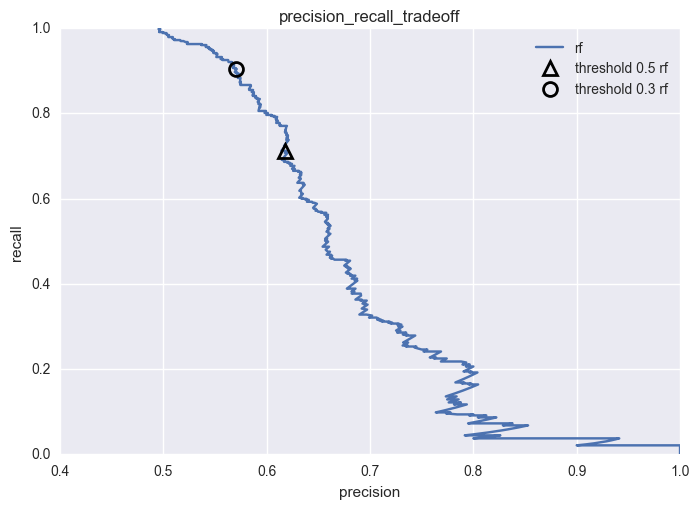

In [144]:
plt.plot(precision_rf, recall_rf, label="rf")

# default proba: 0.5
close_default_rf = np.argmin(np.abs(proba_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10, 
         label="threshold 0.5 rf", fillstyle="none", c='k', mew=2)

# default proba: 0.3  increase recall
close_default_rf = np.argmin(np.abs(proba_rf - 0.3))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], 'o', markersize=10, 
         label="threshold 0.3 rf", fillstyle="none", c='k', mew=2)


plt.xlabel('precision')
plt.ylabel("recall")
plt.legend(loc="best")
plt.title("precision_recall_tradeoff");

plt.plot()

In [145]:
from sklearn.metrics import f1_score
print("f1_score of random forest : {0:.2f}".format(f1_score(y_test, grid.predict(X_test))))
from sklearn.metrics import average_precision_score
ap_rf = average_precision_score(y_test, grid.predict_proba(X_test)[:, 1])
print("average precision score of random forest : {0:.2f}".format(ap_rf))

f1_score of random forest : 0.66
average precision score of random forest : 0.68


In [148]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, grid.predict(X_test))
print(confusion)


[[250 187]
 [123 304]]


In [156]:
np.unique(y_test)

array([0, 1])

In [160]:
from sklearn.metrics import classification_report
print(classification_report(y_test, grid.predict(X_test), target_names=['not click', 'click']))


             precision    recall  f1-score   support

  not click       0.67      0.57      0.62       437
      click       0.62      0.71      0.66       427

avg / total       0.64      0.64      0.64       864



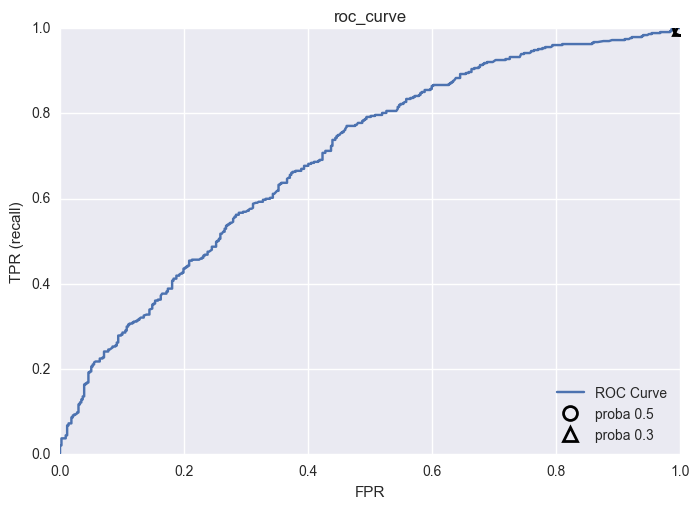

In [161]:
from sklearn.metrics import roc_curve
fpr, tpr, proba = roc_curve(y_test, grid.predict_proba(X_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel('FPR')
plt.ylabel("TPR (recall)")
plt.title("roc_curve")
close_zero = np.argmin(np.abs(proba) - 0.5)
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
         label='proba 0.5', fillstyle="none", c='k', mew=2)


close_zero = np.argmin(np.abs(proba) - 0.3)  # proba == 0.3
plt.plot(fpr[close_zero], tpr[close_zero], '^', markersize=10, 
         label='proba 0.3', fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

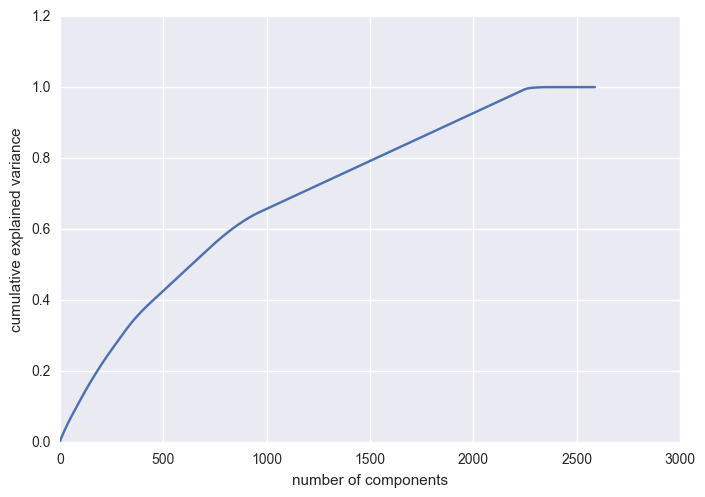

In [162]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance");

In [163]:
data.shape

(3453, 4658)

In [170]:
pca = PCA(n_components=1500)
pca.fit(X_train_scaled)
X_pca = pca.transform(X_train_scaled)
X_pca_test = pca.transform(X_test_scaled)
print("Original shape: %s" % str(X_train_scaled.shape))
print("Reduced shape: %s" % str(X_pca.shape))


Original shape: (2589, 4658)
Reduced shape: (2589, 1500)


In [174]:
print(pca.explained_variance_)

[ 11.42945238   6.68127707   6.3705041  ...,   0.99873397   0.99827523
   0.9968296 ]


In [175]:
# use pca components as features 
param_grid = {'randomforestclassifier__n_estimators': [50, 100], 
              'randomforestclassifier__max_depth': [10, 50, 100]}
pipe = make_pipeline(RandomForestClassifier())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_pca, y_train)
print("train score: {0:.3}".format(grid.score(X_pca, y_train)))
print("test score: {0:.3}".format(grid.score(X_pca_test, y_test)))

train score: 0.997
test score: 0.606


In [177]:
print(classification_report(y_test, grid.predict(X_pca_test), target_names=['not click', 'click']))

             precision    recall  f1-score   support

  not click       0.61      0.62      0.61       437
      click       0.60      0.59      0.60       427

avg / total       0.61      0.61      0.61       864



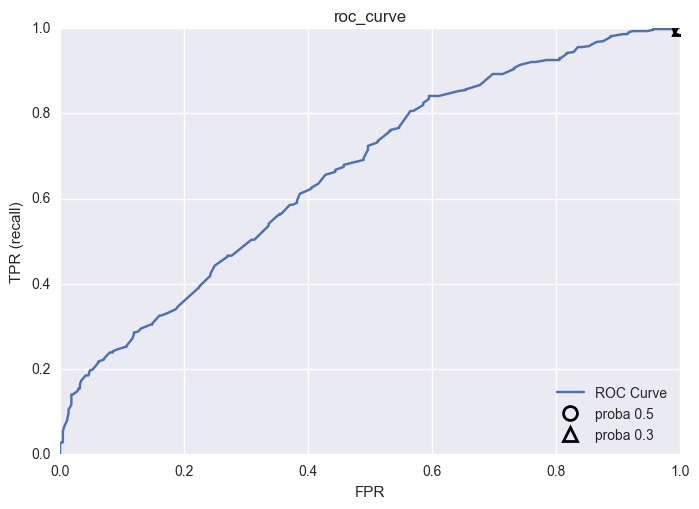

In [178]:
fpr, tpr, proba = roc_curve(y_test, grid.predict_proba(X_pca_test)[:, 1])

plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel('FPR')
plt.ylabel("TPR (recall)")
plt.title("roc_curve")
close_zero = np.argmin(np.abs(proba) - 0.5)
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10, 
         label='proba 0.5', fillstyle="none", c='k', mew=2)


close_zero = np.argmin(np.abs(proba) - 0.3)  # proba == 0.3
plt.plot(fpr[close_zero], tpr[close_zero], '^', markersize=10, 
         label='proba 0.3', fillstyle="none", c='k', mew=2)

plt.legend(loc=4)

[]

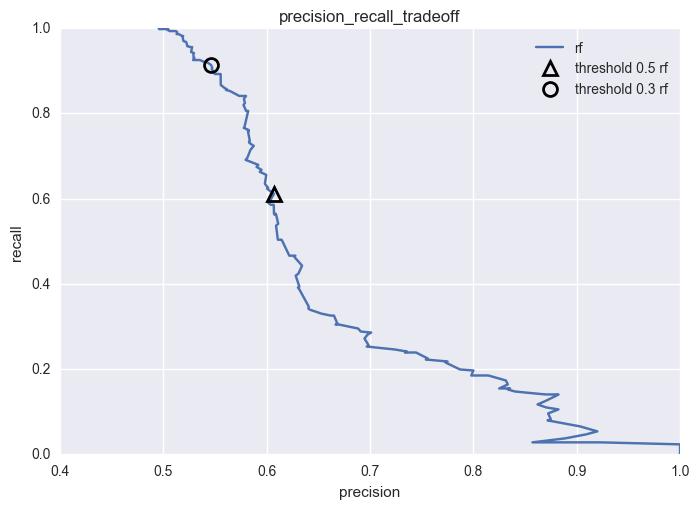

In [179]:
precision_rf, recall_rf, proba_rf = precision_recall_curve(y_test, grid.predict_proba(X_pca_test)[:, 1]) 

plt.plot(precision_rf, recall_rf, label="rf")

# default proba: 0.5
close_default_rf = np.argmin(np.abs(proba_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', markersize=10, 
         label="threshold 0.5 rf", fillstyle="none", c='k', mew=2)

# default proba: 0.3  increase recall
close_default_rf = np.argmin(np.abs(proba_rf - 0.3))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], 'o', markersize=10, 
         label="threshold 0.3 rf", fillstyle="none", c='k', mew=2)


plt.xlabel('precision')
plt.ylabel("recall")
plt.legend(loc="best")
plt.title("precision_recall_tradeoff");

plt.plot()

In [180]:
print("f1_score of random forest : {0:.2f}".format(f1_score(y_test, grid.predict(X_pca_test))))
ap_rf = average_precision_score(y_test, grid.predict_proba(X_pca_test)[:, 1])
print("average precision score of random forest : {0:.2f}".format(ap_rf))

f1_score of random forest : 0.60
average precision score of random forest : 0.66
